# Data Engineer Assistant

## Load the required libraries

In [1]:
import io
import os
import time
import json
from PIL import Image
from pathlib import Path
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta.threads import Run
from openai.types.beta.threads.messages import MessageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

## Load the environment variables

In [2]:
load_dotenv()

api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
model_deployment_name = os.getenv("OPENAI_MODEL_DEPLOYMENT")

## Create an AzureOpenAI client

In [3]:
client = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=api_endpoint,
    api_version="2024-02-15-preview"
)

## Create Table in Databricks UC

In [4]:
def create_databricks_table(table_schema: str, table_name: str) -> None:
    # Call the API to create a table
    print("table_schema:", table_schema, "table_name:", table_name)

## Define the Assistant tools

In [5]:
tools_list = [
    {
        "type": "code_interpreter"
    },
    {
        "type": "function",
        "function": {
            "name": "create_databricks_table",
            "description": "Extract information from a CSV file and create a Databricks UC Table.",
            "parameters": {
                "type": "object",
                "properties": {
                    "table_schema": {
                        "type": "string",
                        "enum": ["energy", "HR"],
                        "description": "The table schema on Databricks UC."
                    },
                    "table_name": {
                        "type": "string",
                        "description": "The table name on Databricks UC."
                    }
                },
                "required": ["table_schema", "table_name"]
            },
        },
    }
]

## Upload the data

In [6]:
with Path("../data/turbines.csv").open("rb") as f:
    assistants_file = client.files.create(file=f, purpose="assistants")

file_ids = [assistants_file.id]

## Create an Assistant and a Thread

In [7]:
instructions = """
You are a data engineering assistant skilled in data analysis, capable of aggregating relevant information from CSV files and providing insights.
You are also proficient in Databricks and assist in creating Databricks UC Tables with the data.
"""
# instructions += r"\n請使用繁體中文回答"

assistant = client.beta.assistants.create(
  name="Data Engineer Assistant",
  instructions=instructions,
  tools=tools_list,
  model=model_deployment_name,
  file_ids=file_ids
)

thread = client.beta.threads.create()

## Process Function calling

In [8]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    tool_outputs = []

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "create_databricks_table":
            create_databricks_table(
                table_schema=arguments["table_schema"], 
                table_name=arguments["table_name"]
            )
            tool_outputs.append(
                {
                    "tool_call_id": action["id"], 
                    "output": "The table has been created successfully."
                }
            )
        else:
            raise ValueError(f"Unknown function: {func_name}")

    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

## Format and display the Assistant Messages for text and images

In [9]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    message_list.reverse()

    for message in message_list:
        for item in message.content:
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                display(image)

## Process the user messages

In [10]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            call_functions(client, thread, run)
        else:
            time.sleep(5)

## Have a conversation with the Assistant

In [11]:
process_message("What kind of data is this?")

processing...
user:
What kind of data is this?

assistant:
The uploaded file contains data in a CSV format with the following columns:

- `Turbine_ID`: A numerical identifier for the turbine.
- `Wind_Speed`: The wind speed (assumed to be in some unit like mph or km/h).
- `RPM`: Revolutions per minute of the turbine.
- `Voltage`: The voltage output from the turbine.
- `Maintenance_Date`: The date when maintenance was last performed on the turbine.

This data appears to be related to the operational parameters and maintenance schedule of wind turbines.



processing...
user:
Provide me with a beautiful analytical chart.



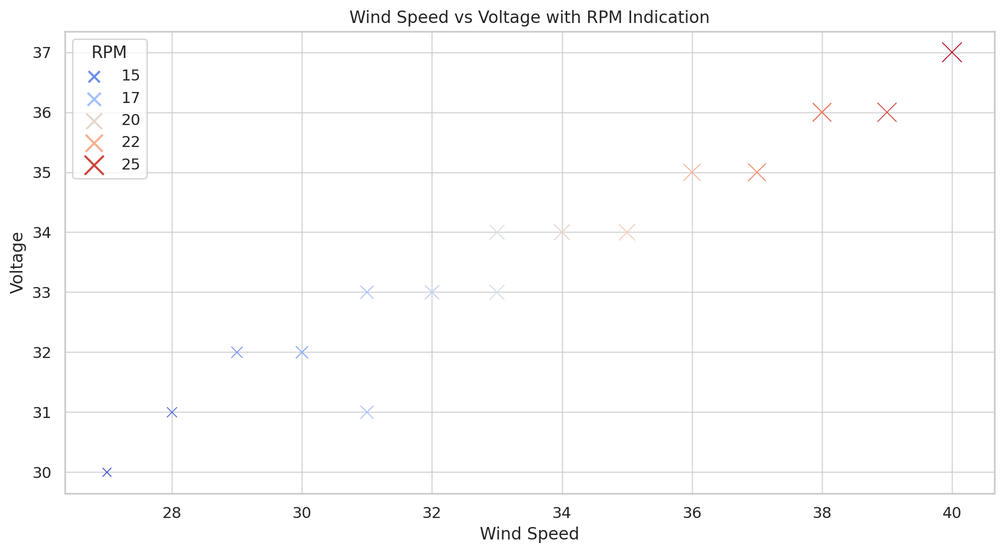

assistant:
Here is an analytical chart that visualizes the relationship between Wind Speed and Voltage for the wind turbines. Each point represents a turbine, with the color and size indicating the RPM (Revolutions Per Minute). This allows us to see if there's any correlation between these parameters and also visually identify the impact RPM might have on the Voltage for various Wind Speeds.

You can [download the chart here](sandbox:/mnt/data/wind_speed_vs_voltage.png).



In [12]:
process_message("Provide me with a beautiful analytical chart.")

In [13]:
# Function Calling
process_message("Please create a Databricks table from the data in the energy schema.")

processing...
table_schema: energy table_name: wind_turbine_data
user:
Please create a Databricks table from the data in the energy schema.

assistant:
The Databricks table named "wind_turbine_data" has been created successfully in the `energy` schema from the data.



In [14]:
# Code Interpreter
process_message("Use PySpark to query the top ten records of this table.")

processing...
user:
Use PySpark to query the top ten records of this table.

assistant:
Unfortunately, we cannot execute a PySpark query within this environment, as the PySpark library is not available. However, for Databricks or any other environment with PySpark set up, you can use the following code snippet to query the top ten records of the table:

```python
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("query_top_ten_records").getOrCreate()

# Read the table into a Spark DataFrame
wind_turbine_df = spark.table("energy.wind_turbine_data")

# Use PySpark SQL to query the top ten records
top_ten_records = wind_turbine_df.limit(10)

# Show the results
top_ten_records.show()
```

You'd run this code within a Databricks notebook or any other environment where you have PySpark available. If you need to retrieve the top ten records within this current environment, I can do so using Pandas. Would you like me to proceed with that?



## Cleanup

In [15]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)

for file_id in file_ids:
    client.files.delete(file_id)